In [1]:
import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample_poly, butter,lfilter
from scipy import signal
from scipy.fft import fft
import pywt
import cv2
import pickle
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# Functions

In [2]:
def load_file(subject_id, base, train, include_EOG=False, include_EOG_run=False):
    """
    one file is one session
    9 runs per each session (except A04T)
    1~3 runs : EOG Eyes open/closed/movement
    4~9 runs : 48 trials per each run (12 trials per class)
    """
    if train:
        file = f"{base}/A0{subject_id}T.mat" 
    else:
        file = f"{base}/A0{subject_id}E.mat"
        
    print("\n#### Load file ####")
    print("Load data from:", file)
    if include_EOG_run:
        data = loadmat(file, squeeze_me=True)['data']
    else:
        data = loadmat(file, squeeze_me=True)['data'][-6:]
    
    loaded_runs = []
    for i, run in enumerate(data):
        X = run['X'].item() 
        X = X.T # (channels, time samples)
        X = X if include_EOG else X[0:22, :]
        
        y = run['y'].item()
        y = y.astype(int)
        y = y - 1 # In matlab, index starts from 1
        
        onsets = run['trial'].item()
        onsets = onsets - 1 # In matlab, index starts from 1
        
        artifacts = run['artifacts'].item()
        fs = run['fs'].item()
        misc = {'gender': run['gender'], 'age': run['age'].item(), 'classes':run['classes']}
        
        loaded_runs.append({"X":X, "y":y, "onsets":onsets, "artifacts":artifacts, "fs":fs, "misc":misc})
        
        print(f"\trun {i} - X shape: {X.shape} y shape: {y.shape} | X max: {X.max()} X min: {X.min()}")
        
    return loaded_runs


In [3]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order, axis=-1):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = lfilter(b, a, data, axis=axis)
    return y

In [4]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order, axis=-1):
    b, a = butter_lowpass(cutoff, fs, order)
    y = lfilter(b, a, data, axis=axis)
    return y

In [5]:
def eeg_lowpass(runs, cutoff, butter_order, axis):
    lowpass_runs = []
    
    print(f"\n#### Lowpass ####")
    for i, run in enumerate(runs):
        fs = run["fs"] # (channels, time samples)
        X = run["X"]
        y = run["y"]
        X = butter_lowpass_filter(X, cutoff=cutoff, fs=fs, order=butter_order, axis=axis)
        
        lowpass_runs.append({"X":X, "y":y, "onsets":run["onsets"], "fs":fs})
        
        print(f"\trun {i} - X shape: {X.shape} y shape: {y.shape} | lowpass {cutoff}Hz ")
    return lowpass_runs

def eeg_resample_poly_line(runs, fs):
    resampled_runs = []
    
    print(f"\n#### Resample poly ####")
    for i, run in enumerate(runs):
        X = run["X"] # (channels, time samples)
        y = run["y"]
        fs_origin = run["fs"]
        event_onsets = run["onsets"]

        X = resample_poly(X, up=fs, down=fs_origin, axis=1, padtype="line") 

        event_onsets = event_onsets / fs_origin * fs
        event_onsets = event_onsets.round().astype(int)

        resampled_runs.append({"X":X, "y":y, "onsets":event_onsets, "fs":fs})
        
        print(f"\trun {i} - X shape: {X.shape} y shape: {y.shape} | from {fs_origin}Hz to {fs}Hz")
    return resampled_runs

def eeg_bandpass(runs ,lowcut, highcut, butter_order, axis):
    bandpass_runs = []
    
    print(f"\n#### Bandpass ####")
    for i, run in enumerate(runs):
        fs = run["fs"]
        X = run["X"] # (channels, time samples)
        y = run["y"]
        X = butter_bandpass_filter(X, lowcut=lowcut, highcut=highcut, fs=fs, order=butter_order, axis=axis) 

        bandpass_runs.append({"X":X, "y":y, "onsets":run["onsets"], "fs":fs})
        
        print(f"\trun {i} - X shape: {X.shape} y shape: {y.shape} | {lowcut}-{highcut}Hz ")
    return bandpass_runs

def eeg_ica(runs, show_plot=False, verbose=False, return_EOG=True, random_state=97):
    ica_runs = []

    # Definition of channel types and names
    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                 'eeg', 'eeg', 'eog', 'eog', 'eog']
    ch_names = ['Fz',  'FC3', 'FC1', 'FCz', 'FC2',
                 'FC4', 'C5',  'C3',  'C1',  'Cz',
                 'C2',  'C4',  'C6',  'CP3', 'CP1',
                 'CPz', 'CP2', 'CP4', 'P1',  'Pz',
                 'P2',  'POz', 'EOG-left', 'EOG-central', 'EOG-right']
    if show_plot:
        with open("montage.pkl", "rb") as f:
            montage = pickle.load(f)
            
    print(f"\n#### ICA ####")
    print(f"\t*return_EOG: {return_EOG}")
    for i, run in enumerate(runs):
        sfreq = run["fs"] # Sampling frequency
        data = run['X'].copy() * 1e-06 # (channels, time samples); from microvolt to volt
        y = run["y"]

        # Create Raw
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
        raw = mne.io.RawArray(data, info, verbose=verbose)
        raw.info["lowpass"] = highcut
        raw.info["highpass"] = lowcut
        raw._filenames = ['temp']
        if show_plot:
            copy_raw = raw.copy()
        
        # Fit ICA
        ica = ICA(max_iter="auto", random_state=random_state, verbose=verbose)
        ica.fit(raw)

        # Find artifact using EOG
        eog_indices, eog_scores = ica.find_bads_eog(raw, verbose=verbose)
        ica.exclude = eog_indices
        if show_plot:
            ica.info.set_montage(montage)
            ica.plot_scores(eog_scores)
            ica.plot_components()
        
        # Remove artifact and reconstruct Raw
        ica.apply(raw)
        X = raw.get_data() * 1e06 # from volt to microvolt
        if not return_EOG:
            X = X[0:22, :] # (channels, time samples)
        if show_plot:
            copy_raw.plot(show_scrollbars=False);
            raw.plot(show_scrollbars=False);
        
        # Result
        ica_runs.append({"X":X, "y":y, "onsets":run["onsets"], "fs":sfreq})
        print(f"\trun {i} - X shape: {X.shape} y shape: {y.shape} | selected ICs: {eog_indices}")
    
    return ica_runs

def eeg_split_trials(runs, start_sec_after_onset, finish_sec_after_onset):
    epoched_runs = []
    print(f"\n#### Split trials ####")
    
    for i, run in enumerate(runs):
        X = run["X"]  # (channels, time samples)
        y = run["y"]
        onsets = run["onsets"]
        fs     = run["fs"]
        trials = []
        for onset in onsets:
            from_time = onset + round(start_sec_after_onset * fs)
            to_time   = onset + round(finish_sec_after_onset * fs)

            trial = X[:, from_time:to_time]
            trials.append(trial)
        trials = np.stack(trials, axis=0)  # (n_trials, n_channels, n_time)
        epoched_runs.append({"X":trials, "y":y, "onsets":run["onsets"], "fs":run["fs"]})
        
        print(f"\trun {i} - X shape: {trials.shape} y shape: {y.shape}")
    return epoched_runs

def eeg_class_binarize(runs):
    binary_runs = []
        
    print("\n#### Binarize ####")
    for i, run in enumerate(runs):
        X = run["X"]
        y = run["y"]
        
        # 0:left hand, 1:right hand, 2:feet, 3:tongue
        binary_mask = (y == 1) + (y == 2) # (right hand, feet)
        
        X_bin = X[binary_mask] # (144, 22, 1750)
        y_bin = y[binary_mask] # (144,)
        y_bin = y_bin - 1 # {1:right hand, 2:feet} -> {0:right hand, 1:feet} 
        
        binary_runs.append({"X":X_bin, "y":y_bin, "onsets":run["onsets"], "fs":run["fs"]})
        
        y_unique_before = np.unique(y, return_counts=True)
        y_unique_after = np.unique(y_bin, return_counts=True)
        print(f"\trun {i} - X shape: {X_bin.shape} y shape: {y_bin.shape} | y unique before: {y_unique_before} y unique after: {y_unique_after}")
    
    return binary_runs

def eeg_merge_runs(runs):
    print(f"\n#### Merge runs ####")
    X = np.concatenate([run["X"] for run in runs], axis=0)
    y = np.concatenate([run["y"] for run in runs], axis=0)
    print(f"\tX shape: {X.shape} y shape: {y.shape}")
    return X, y

In [6]:
def morlet_custom(M, a, beta):
    """
    Args
    ----
        M : length.
        a : scale parameter, equals s in original morlet function of scipy.signal.
        beta : parameter.
        
    The period of this wavelet is (2*a)/fs. The frequency of this wavelet is 1/(2*a)*fs. fs is the sampling rate.
    """
    x = np.arange(0, M) - (M - 1.0) / 2
    x = x / a
    wavelet = np.exp(-beta ** 2 * x ** 2 / 2) * np.cos(np.pi * x)
    output = np.sqrt(1/a) * wavelet
    return output

def freq2scale(frequencies, fs):
    """
    a = 1/(2*f) * fs
    where a is the scale, f is the frequency and fs is the sampling rate.
    """
    scales = []
    for f in frequencies:
        a = 1/(2*f) * fs
        scales.append(a)
    return scales

def wavelet_entropy(cwt_img):
    coef = abs(cwt_img)
    d = coef / coef.sum()
    En = - (d * np.log(d+1e-6)).sum()
    return En

def apply_cwt(x, crop_freq, fs, resize_size, betas=None, return_best_beta=False, return_betas_entropies=False, verbose=0):
    """
    Args
    ----
        x           : vector (N,)
        crop_freq   : list[from_freq, to_freq] in Hz.
        fs          : target sampling rate
        resize_size : list[height, width]
    Return
    ------
        out : CWT image
    """
    from_freq, to_freq = crop_freq
    
    ### Find Best Beta ###
    scales = freq2scale(np.arange(1,65), fs) # num: 64
    if betas is None:
        betas = np.arange(0.1, 20, 0.1)
    entropies = []
    for beta in betas:
        x_cwt = signal.cwt(x, morlet_custom, scales, beta=beta)
        x_cwt_abs = abs(x_cwt)
        entropy = wavelet_entropy(x_cwt_abs)
        entropies.append(entropy)
        
        if verbose > 1:
            plt.imshow(x_cwt_abs.clip(min=0.8))
            plt.title(f"beta {beta}")
            plt.colorbar()
            plt.show()
    
    min_entropy_index = np.array(entropies).argmin()
    best_beta = betas[min_entropy_index]
    
    ### CONTINUOS WAVELET TRANSFORM ###
    scales = freq2scale(np.arange(1,65), fs) # num: 64
    x_cwt_best = signal.cwt(x, morlet_custom, scales, beta=best_beta)
    x_cwt_best_abs = abs(x_cwt_best)
    
    if verbose > 0:
        img = x_cwt_best_abs / 10
        img = img.clip(min=0.8)
        plt.imshow(img, aspect=5)
        plt.title(f"Best Beta {best_beta}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
    
    ### CROP ### 
    x_crop = x_cwt_best_abs[from_freq-1:to_freq, :]
    
    if verbose > 0:
        img = x_crop/10
        img = img.clip(min=0.8)
        plt.imshow(img, aspect=20)
        plt.title("Crop")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()

    ### RESIZE ###
    x_resize = cv2.resize(x_crop, dsize=resize_size, interpolation=cv2.INTER_LINEAR)
    
    if verbose > 0:
        img = x_resize / 10
        img = img.clip(min=0.8)
        plt.imshow(img)
        plt.title("Resize")
        plt.colorbar()
        plt.show()
        
    out = x_resize
    
    assert not (return_best_beta and return_betas_entropies)
    if return_betas_entropies:
        return out, (betas, entropies)
    elif return_best_beta:
        return out, best_beta
    else:
        return out

In [7]:
def plot_fft(sig, Fs):
    N = len(sig)
    T = N / Fs
    x = np.arange(N) / T
    y = abs(fft(sig))
    pk = max(y)# peak

    x = x[:int(N/2)]
    y = y[:int(N/2)]

    plt.plot(x, y, "tab:orange")
    plt.xlabel("frequency (Hz)")
    plt.show()

# Configuration

In [8]:
# Origin
data_path = "../data/BCICIV_2a/mat"
output_path = "cwt_data/2a"

# Resample
fs_origin = 250
fs        = 128 # Hz

# Bandpass
lowcut       = 1   # Hz
highcut      = 50  # Hz
butter_order = 4

# Split trials
from_time = 2 # sec
to_time   = 6 # sec

# CWT beta search space
# betas = np.arange(0.1, 4, 0.1)
betas = [0.4]

# CWT Crop
from_freq = 7  # Hz
to_freq   = 30 # Hz

# CWT Resize
resize_size = (64,64)

# Generate preprocessed data

##############################
Subject2 Train
##############################

#### Load file ####
Load data from: ../data/BCICIV_2a/mat/A02T.mat
	run 0 - X shape: (25, 96735) y shape: (48,) | X max: 311.5234375 X min: -166.9921875
	run 1 - X shape: (25, 96735) y shape: (48,) | X max: 330.078125 X min: -263.18359375
	run 2 - X shape: (25, 96735) y shape: (48,) | X max: 333.984375 X min: -339.84375
	run 3 - X shape: (25, 96735) y shape: (48,) | X max: 357.91015625 X min: -409.66796875
	run 4 - X shape: (25, 96735) y shape: (48,) | X max: 392.578125 X min: -258.30078125
	run 5 - X shape: (25, 96735) y shape: (48,) | X max: 362.79296875 X min: -265.13671875


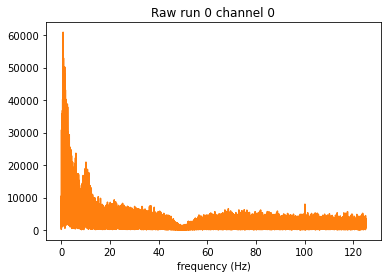


#### Lowpass ####
	run 0 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 1 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 2 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 3 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 4 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 5 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 


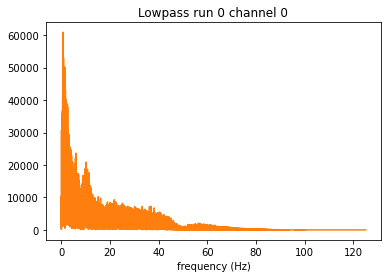


#### Resample poly ####
	run 0 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 1 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 2 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 3 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 4 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 5 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz


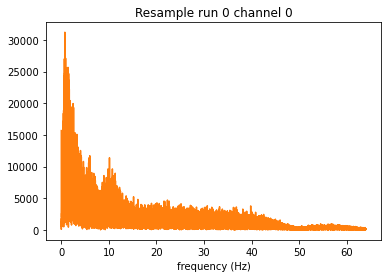


#### Bandpass ####
	run 0 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 1 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 2 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 3 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 4 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 5 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 


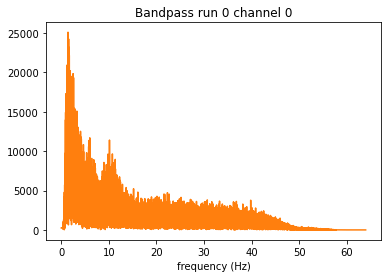


#### ICA ####
	*return_EOG: False
	run 0 - X shape: (22, 49529) y shape: (48,) | selected ICs: [1]
	run 1 - X shape: (22, 49529) y shape: (48,) | selected ICs: [1]
	run 2 - X shape: (22, 49529) y shape: (48,) | selected ICs: [1]
	run 3 - X shape: (22, 49529) y shape: (48,) | selected ICs: [0]
	run 4 - X shape: (22, 49529) y shape: (48,) | selected ICs: [1, 2]
	run 5 - X shape: (22, 49529) y shape: (48,) | selected ICs: [0, 3]

#### Split trials ####
	run 0 - X shape: (48, 22, 512) y shape: (48,)
	run 1 - X shape: (48, 22, 512) y shape: (48,)
	run 2 - X shape: (48, 22, 512) y shape: (48,)
	run 3 - X shape: (48, 22, 512) y shape: (48,)
	run 4 - X shape: (48, 22, 512) y shape: (48,)
	run 5 - X shape: (48, 22, 512) y shape: (48,)

#### Binarize ####
	run 0 - X shape: (24, 22, 512) y shape: (24,) | y unique before: (array([0, 1, 2, 3]), array([12, 12, 12, 12])) y unique after: (array([0, 1]), array([12, 12]))
	run 1 - X shape: (24, 22, 512) y shape: (24,) | y unique before: (array([0, 1, 2

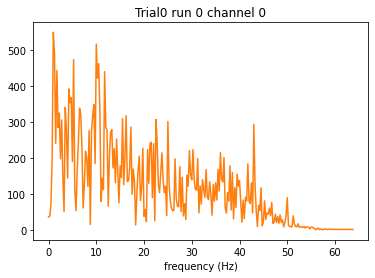

  0%|          | 0/144 [00:00<?, ?it/s]


#### Apply CWT ####


100%|██████████| 144/144 [00:54<00:00,  2.65it/s]


	X shape: (144, 22, 64, 64) y shape: (144,)
##############################
Subject2 TEST
##############################

#### Load file ####
Load data from: ../data/BCICIV_2a/mat/A02E.mat
	run 0 - X shape: (25, 96735) y shape: (48,) | X max: 321.77734375 X min: -162.59765625
	run 1 - X shape: (25, 96735) y shape: (48,) | X max: 466.30859375 X min: -544.43359375
	run 2 - X shape: (25, 96735) y shape: (48,) | X max: 374.51171875 X min: -454.1015625
	run 3 - X shape: (25, 96735) y shape: (48,) | X max: 252.9296875 X min: -285.64453125
	run 4 - X shape: (25, 96735) y shape: (48,) | X max: 341.30859375 X min: -354.98046875
	run 5 - X shape: (25, 96735) y shape: (48,) | X max: 331.0546875 X min: -233.3984375


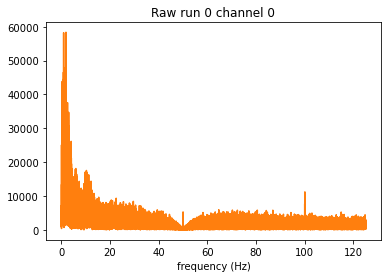


#### Lowpass ####
	run 0 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 1 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 2 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 3 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 4 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 
	run 5 - X shape: (25, 96735) y shape: (48,) | lowpass 50Hz 


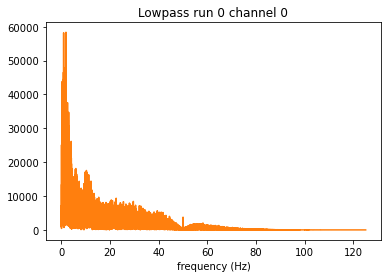


#### Resample poly ####
	run 0 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 1 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 2 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 3 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 4 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz
	run 5 - X shape: (25, 49529) y shape: (48,) | from 250Hz to 128Hz


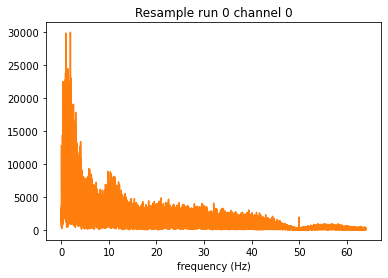


#### Bandpass ####
	run 0 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 1 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 2 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 3 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 4 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 
	run 5 - X shape: (25, 49529) y shape: (48,) | 1-50Hz 


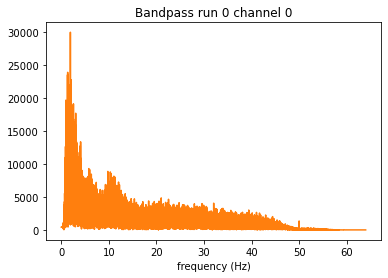


#### ICA ####
	*return_EOG: False
	run 0 - X shape: (22, 49529) y shape: (48,) | selected ICs: [1]
	run 1 - X shape: (22, 49529) y shape: (48,) | selected ICs: [2, 7]
	run 2 - X shape: (22, 49529) y shape: (48,) | selected ICs: [4, 0]
	run 3 - X shape: (22, 49529) y shape: (48,) | selected ICs: [4]
	run 4 - X shape: (22, 49529) y shape: (48,) | selected ICs: [4]
	run 5 - X shape: (22, 49529) y shape: (48,) | selected ICs: [5]

#### Split trials ####
	run 0 - X shape: (48, 22, 512) y shape: (48,)
	run 1 - X shape: (48, 22, 512) y shape: (48,)
	run 2 - X shape: (48, 22, 512) y shape: (48,)
	run 3 - X shape: (48, 22, 512) y shape: (48,)
	run 4 - X shape: (48, 22, 512) y shape: (48,)
	run 5 - X shape: (48, 22, 512) y shape: (48,)

#### Binarize ####
	run 0 - X shape: (24, 22, 512) y shape: (24,) | y unique before: (array([0, 1, 2, 3]), array([12, 12, 12, 12])) y unique after: (array([0, 1]), array([12, 12]))
	run 1 - X shape: (24, 22, 512) y shape: (24,) | y unique before: (array([0, 1, 2

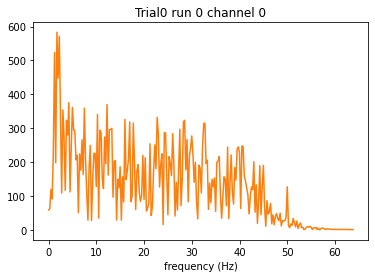

  0%|          | 0/144 [00:00<?, ?it/s]


#### Apply CWT ####


100%|██████████| 144/144 [00:48<00:00,  2.95it/s]

	X shape: (144, 22, 64, 64) y shape: (144,)

#### Merge train and test ####
	X shape: (288, 22, 64, 64) y sahpe: (288,)

#### 10 Folds ####
fold 0 - #train: (259,), #test: (29,)
fold 1 - #train: (259,), #test: (29,)
fold 2 - #train: (259,), #test: (29,)
fold 3 - #train: (259,), #test: (29,)
fold 4 - #train: (259,), #test: (29,)
fold 5 - #train: (259,), #test: (29,)
fold 6 - #train: (259,), #test: (29,)
fold 7 - #train: (259,), #test: (29,)
fold 8 - #train: (260,), #test: (28,)
fold 9 - #train: (260,), #test: (28,)


In [9]:
subject_id = 2
rn = 0 # run index
ch = 0 # channel index
tr = 0 # trial index
with_plot = True

data = {"X":[], "y":[], "folds":None}
best_betas = []

for TRAIN in [True, False]:
    print(f"##############################\nSubject{subject_id} {'Train' if TRAIN else 'TEST'}\n##############################")
    
    # 1. Run을 불러온다
    runs = load_file(subject_id, base=data_path, train=TRAIN, include_EOG=True, include_EOG_run=False)
    if with_plot:
        temp = runs[rn]["X"][ch] # run, X, channel
        plt.title(f"Raw run {rn} channel {ch}")
        plot_fft(temp, fs_origin)

    # 2. Run을 lowpass 한다.
    runs = eeg_lowpass(runs, cutoff=50, butter_order=butter_order, axis=1)
    if with_plot:
        temp = runs[rn]["X"][ch] # run, X, channel
        plt.title(f"Lowpass run {rn} channel {ch}")
        plot_fft(temp, fs_origin)

    # 3. Run을 resample한다. 128Hz
    runs = eeg_resample_poly_line(runs, fs=fs)
    if with_plot:
        temp = runs[rn]["X"][ch] # run, X, channel
        plt.title(f"Resample run {rn} channel {ch}")
        plot_fft(temp, fs)

    # 4. Run을 bandpass한다. 1~50Hz
    runs = eeg_bandpass(runs, lowcut=lowcut, highcut=highcut, butter_order=butter_order, axis=1)
    if with_plot:
        temp = runs[rn]["X"][ch] # run, X, channel
        plt.title(f"Bandpass run {rn} channel {ch}")
        plot_fft(temp, fs)

    # 5. Run을 ICA한다.
    runs = eeg_ica(runs, return_EOG=False, show_plot=False)

    # 6. Run을 trial로 쪼갠다. Cue+0~4sec
    runs = eeg_split_trials(runs, start_sec_after_onset=from_time, finish_sec_after_onset=to_time)

    # 7. Run마다 binary 데이터로 바꾼다.
    runs = eeg_class_binarize(runs)

    # 8. Run을 모두 합친다.
    X, y = eeg_merge_runs(runs)
    if with_plot:
        temp = runs[rn]["X"][tr][ch] # run, X, trial, channel
        plt.title(f"Trial{tr} run {rn} channel {ch}")
        plot_fft(temp, fs)

    # 9. Trial에 대해서 wavelet entropy 를 구한다. Beta 0.1~20
    # 10. Trial의 최적 beta를 선택한다. Minimum wavelet entropy
    # 11. Trial을 cwt해서 이미지를 얻는다.
    # 12. 이미지를 7~30Hz, 0~4sec만큼 Crop한다. 
    # 13. 이미지를 64×64로 리사이징한다.

    # 14. 모든 채널에 대해서 7~11을 반복한다.
    print(f"\n#### Apply CWT ####")
    X_cwt = []

    for trial in tqdm(X):
        cwt_imgs = []
        for channel in trial:
            cwt_img, best_beta = apply_cwt(channel, crop_freq=[from_freq,to_freq], fs=fs, resize_size=resize_size,
                                betas=betas, return_best_beta=True)
            cwt_imgs.append(cwt_img)
            best_betas.append(best_beta)
        trial_cwt = np.stack(cwt_imgs, axis=0)
        X_cwt.append(trial_cwt)
    X_cwt = np.stack(X_cwt, axis=0)
    print(f"\tX shape: {X_cwt.shape} y shape: {y.shape}")
    
    data["X"].append(X_cwt)
    data["y"].append(y)

# 15. Train 과 Test를 합친다.
print(f"\n#### Merge train and test ####")
data["X"] = np.concatenate(data["X"], axis=0)
data["y"] = np.concatenate(data["y"], axis=0)
print(f"\tX shape: {data['X'].shape} y sahpe: {data['y'].shape}")
    
# 16. 10 fold cv
print(f"\n#### 10 Folds ####")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020011075)
skf.get_n_splits(data["X"], data["y"])
folds = []

for i, (train_index, test_index) in enumerate(skf.split(data["X"], data["y"])):
    folds.append((train_index, test_index))
    print(f"fold {i} - #train: {train_index.shape}, #test: {test_index.shape}")

data["folds"] = folds

In [10]:
# 17. Save
save_path = f"{output_path}/A0{subject_id}_64x64_scipy2_ica_cv10.pkl"
print(f"\n#### 10 Folds ####")
print("Save data at:", save_path)

with open(save_path, "wb") as f:
    data["comment"] = "lowpass-resample_poly-bandpass, 4seconds, beta 0.4, ica"
    pickle.dump(data, f)

print(f"\n@@@subject {subject_id} done@@@\n")


#### 10 Folds ####
Save data at: cwt_data/2a/A02_64x64_scipy2_ica_cv10.pkl

@@@subject 2 done@@@



---

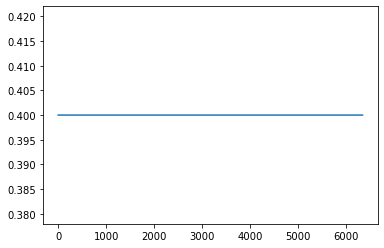

In [11]:
plt.plot(best_betas)

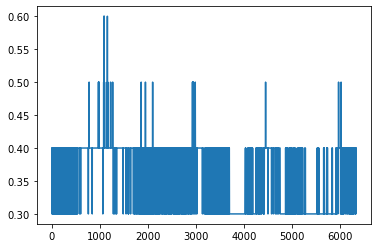

[0.4] [6336]


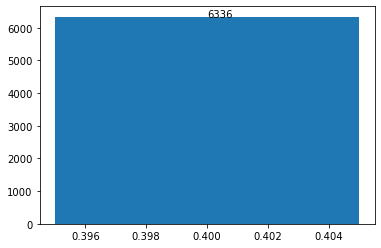

In [12]:
b, counts = np.unique(best_betas, return_counts=True)
print(b, counts)
plt.bar(b, counts, width=0.01)
for _ in zip(b, counts):
    plt.text(_[0], _[1], str(_[1]))

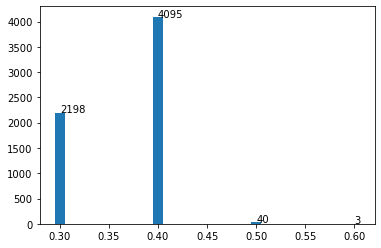

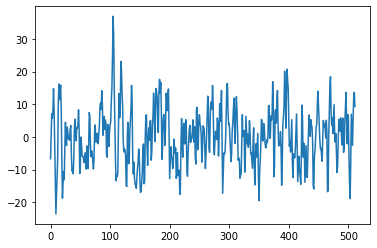

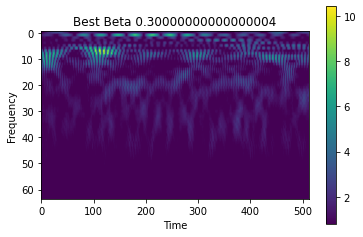

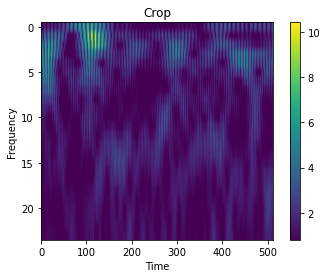

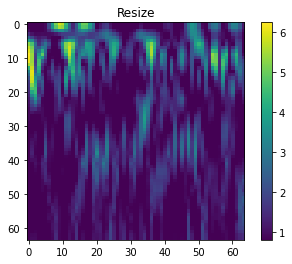

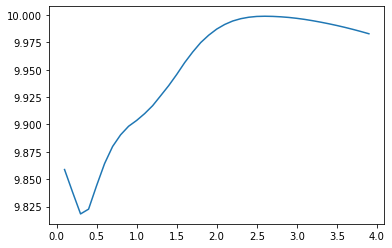

In [13]:
sig = X[94][19] # trial, channel
plt.plot(sig)
plt.show()

cwt_img, (betas, ents) = apply_cwt(sig, crop_freq=[from_freq,to_freq], fs=fs, resize_size=resize_size, betas=np.arange(0.1,4,0.1), verbose=1, return_betas_entropies=True)
plt.plot(betas, ents)
plt.show()

In [14]:
with open(save_path, "rb") as f:
    data = pickle.load(f)
    X = data["X"]
    y = data["y"]
    folds = data["folds"]
    
for i, (train_index, test_index) in enumerate(folds):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test  = X[test_index]
    y_test  = y[test_index]
    
    print("fold", i)
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test",  X_test.shape)
    print("y_test",  y_test.shape)
    print()

fold 0
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 1
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 2
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 3
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 4
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 5
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 6
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 7
X_train (259, 22, 64, 64)
y_train (259,)
X_test (29, 22, 64, 64)
y_test (29,)

fold 8
X_train (260, 22, 64, 64)
y_train (260,)
X_test (28, 22, 64, 64)
y_test (28,)

fold 9
X_train (260, 22, 64, 64)
y_train (260,)
X_test (28, 22, 64, 64)
y_test (28,)

